In [34]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
import os,random
import keras
#os.environ["KERAS_BACKEND"] = "theano"

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_VISIBLE_DEVICE"]  = '0'
#os.environ["THEANO_FLAGS"]  = "floatX=float32"
#os.environ["THEANO_FLAGS"]  = "device=cuda%d"%(1)

In [35]:
import numpy as np
import seaborn as sns
import pickle, random, sys

In [36]:
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
#from keras.optimizers import adam
from tensorflow.keras.optimizers import Adam
#import theano as th
#import theano.tensor as T
import os
WEIGHTS_PATH = ('resnet_like_weights_tf_dim_ordering_tf_kernels.h5')
from keras.models import Model
from keras.layers import Input,Dense,Conv1D,MaxPool1D,ReLU,Dropout,Softmax
from keras.layers import LSTM
import keras
from keras.callbacks import LearningRateScheduler
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
import tensorflow as tf
import importlib,sys

importlib.reload(sys)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Load the dataset ...
#  You will need to seperately download or generate this file
dbfile = open('RML2016.10a_dict.dat', 'rb')      
Xd = pickle.load(dbfile,encoding='latin1') 
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [37]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.9)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [38]:
print('数据集总数：',n_examples)
print('调制方式' , len(mods),'种:' ,mods)
print('信噪比:',snrs)

数据集总数： 220000
调制方式 11 种: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
信噪比: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [39]:
# Y_train = np.argmax(Y_train, axis=-1)
# Y_test = np.argmax(Y_test, axis=-1)

In [40]:
Y_train,Y_test

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

# load data

In [41]:
X_train_feature_expert = pd.read_csv('X_train_feature_expert.csv',header=None).drop(columns=[0],index=[0])
X_test_feature_expert = pd.read_csv('X_test_feature_expert.csv',header=None).drop(columns=[0],index=[0])

X_train_feature_time = pd.read_csv('X_train_feature_time.csv',header=None).drop(columns=[0],index=[0])
X_test_feature_time = pd.read_csv('X_test_feature_time.csv',header=None).drop(columns=[0],index=[0])

X_train_feature_old = pd.read_csv('X_train_feature_old.csv',header=None).drop(columns=[0],index=[0])
X_test_feature_old = pd.read_csv('X_test_feature_old.csv',header=None).drop(columns=[0],index=[0])

In [75]:
# concate time feature and complex feature together
# X_train_feature = np.concatenate((X_train_feature_time, X_train_feature_complex), axis = 1)
# X_test_feature = np.concatenate((X_test_feature_time, X_test_feature_complex), axis = 1)
#choose1
# X_train_feature = X_train_feature_complex
# X_test_feature = X_test_feature_complex
#choose1
X_train_feature = X_train_feature_time
X_test_feature = X_test_feature_time

print(X_train_feature.shape)
print(X_test_feature.shape)

(198000, 132)
(22000, 132)


In [76]:
X_train_feature.shape[0]

198000

In [77]:
# standardize the features

from sklearn.feature_selection import VarianceThreshold
X_all = np.concatenate((X_train_feature, X_test_feature), axis = 0)

s0 = X_train_feature.shape[0]
s1 = X_train_feature.shape[1]

k = 1
interval = int(s1/k)
X_train_std_all_list = []
X_test_std_list = []
sc_train = []
for i in range(k):
    X_all_filter = VarianceThreshold(threshold=(0)).fit_transform(X_all[:,interval*i: interval*(i+1)])
    sc_train.append(StandardScaler())
    print(X_all_filter.shape)
    sc_train[i].fit(X_all_filter)
    X_train_std_all_list.append(sc_train[i].transform(X_all_filter[:s0,:])) 
    X_test_std_list.append(sc_train[i].transform(X_all_filter[s0:,:]))
X_train_std_all = np.concatenate((X_train_std_all_list), axis = 1)
X_test_std = np.concatenate((X_test_std_list), axis = 1)

print("X_train_std_all,", X_train_std_all.shape)
print("X_test_std,", X_test_std.shape)

(220000, 127)
X_train_std_all, (198000, 127)
X_test_std, (22000, 127)


In [78]:
# devide train and val data
from sklearn.model_selection import train_test_split
X_train_std, X_val_std, y_train, y_val = train_test_split(X_train_std_all, Y_train, test_size=0.111, random_state=42)
print("X_train_std,", X_train_std.shape)
print("X_val_std,", X_val_std.shape)
print("X_test_std,", X_test_std.shape)

X_train_std, (176022, 127)
X_val_std, (21978, 127)
X_test_std, (22000, 127)


In [79]:
X_train_std = pd.DataFrame(X_train_std)
X_val_std = pd.DataFrame(X_val_std)
X_test_std = pd.DataFrame(X_test_std)

In [80]:
# inf,nan数据填充
X_train_std = (X_train_std.replace([np.inf, -np.inf], np.nan)).fillna(value = 0) 
X_val_std = (X_val_std.replace([np.inf, -np.inf], np.nan)).fillna(value = 0) 
X_test_std = (X_test_std.replace([np.inf, -np.inf], np.nan)).fillna(value = 0) 

In [81]:
X_train_std.shape,X_test_std.shape

((176022, 127), (22000, 127))

In [82]:
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# CART

In [83]:
from sklearn import datasets,model_selection,metrics,tree,preprocessing
#x=preprocessing.StandardScaler().fit_transform(x)
# 划分训练集、测试集
#x_train,x_test,y_train,y_test=model_selection.train_test_split(X_train_std,y_train,test_size=0.3)
# 导入决策树
model=tree.DecisionTreeClassifier(max_depth=35)
# 模型训练
model.fit(X_train_std.values,y_train)
# 模型预测
y_pred=model.predict(X_val_std.values)
# 模型性能评价
print(metrics.accuracy_score(y_pred,y_val))

0.4932204932204932


In [84]:
# model0:原模型测试
classes = mods
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test_std.values[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]   

    test_Y_i_hat = model.predict(test_X_i)
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    #print("Overall Accuracy: ", cor / (cor+ncor))
    print(cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

0.1424682395644283
0.16466234967622573
0.1636197440585009
0.16385767790262173
0.1687170474516696
0.16756272401433692
0.17853658536585365
0.23145665773011617
0.3553639846743295
0.491585473870682
0.6570915619389587
0.7208672086720868
0.7695067264573991
0.7768090671316478
0.8223624887285843
0.8311444652908068
0.8315696649029982
0.845724907063197
0.8053016453382084
0.8333333333333334


In [85]:
import joblib
joblib.dump(model,'model_saved\Feat_based\CART_FEAT_time.pkl')
model = joblib.load('model_saved\Feat_based\CART_FEAT_time.pkl')

In [18]:
# def plot_confusion_matrix(cm, title='Feature-based Confusion matrix', cmap=plt.cm.Blues, labels=[]):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(labels))
#     plt.xticks(tick_marks, labels, rotation=45)
#     plt.yticks(tick_marks, labels)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [19]:
# # Plot confusion matrix
# classes = mods
# model = model
# test_Y_hat = model.predict(X_val_std)
# conf = np.zeros([len(classes),len(classes)])
# confnorm = np.zeros([len(classes),len(classes)])
# for i in range(0,X_val_std.shape[0]):
#     j = list(Y_test[i,:]).index(1)
#     k = int(np.argmax(test_Y_hat[i,:]))
#     conf[j,k] = conf[j,k] + 1
# for i in range(0,len(classes)):
#     confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
# plot_confusion_matrix(confnorm, labels=classes)
# plt.savefig('pic\Confusion_Matrix\Feat_CM_CART.jpg',dpi = 300)

In [37]:
# 对抗样本生成
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack
from sklearn.metrics import accuracy_score
from art.attacks.evasion import ProjectedGradientDescent,FastGradientMethod

from art.attacks.evasion import CarliniL2Method
def get_adversarial_examples(model, x_test, y_test, EPS, attack = 'PGD'):
    
    # Create ART classifier for scikit-learn DecisionTreeClassifier
    art_classifier = SklearnClassifier(model=model)
    
    # Create ART attack
    if attack == 'FGM':
        attacker = FastGradientMethod(estimator=art_classifier, eps=EPS)
        
    if attack == 'PGD':
        attacker = ProjectedGradientDescent(estimator=art_classifier, norm=1, eps=EPS, eps_step=0.1,
                                            max_iter=10, targeted=False, num_random_init=0, batch_size=1,
                                            verbose=False)
    elif attack == 'CW':
        attacker = CarliniL2Method(classifier=art_classifier, max_iter=20, verbose=False)
    
    elif attack == 'ZOO':
        attacker = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=2, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    x_train_adv = attacker.generate(x_test)

    return x_train_adv

In [38]:
def cal_acc(X_test_std,Y_test,model):
    snr = 10
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test_std[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]   
    test_Y_i_hat = model.predict(test_X_i)
    acc = accuracy_score(test_Y_i, test_Y_i_hat)
    return acc

In [58]:
import joblib
joblib.dump(model,'model_saved\Feat_based\CART_FEAT_basic.pkl')
model = joblib.load('model_saved\Feat_based\CART_FEAT_basic.pkl')

# XGB

In [52]:
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import sklearn
import warnings
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import  pyplot
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt


model_xgb = xgb.XGBClassifier(max_depth=20,tree_method='gpu_hist', gpu_id=0)

clf_multilabel = OneVsRestClassifier(model_xgb)

clf_multilabel.fit(X_train_std.values,y_train)

y_pred=clf_multilabel.predict(X_val_std.values)
# 模型性能评价
print(metrics.accuracy_score(y_pred,y_val))

model_xgb.fit(X_train_std.values,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [60]:
num_round = 10
param = {'objective': 'multi:softprob', 'metric': 'multi_logloss', 'num_class': 11}
train_data = xgb.DMatrix(X_train_std.values, label=y_train)
evallist = [(train_data, 'eval'), (train_data, 'train')]
model = xgb.train(param, train_data, num_round, evallist)

TypeError: train() got an unexpected keyword argument 'tree_method'

In [ ]:
# Create ART classifier for XGBoost
art_classifier = XGBoostClassifier(model=model, nb_features=X_train_std.shape[1], nb_classes=11)
# Create ART Zeroth Order Optimization attack
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)
    
# Generate adversarial samples with ART Zeroth Order Optimization attack
x_train_adv = zoo.generate(X_test_std.values)

ZOO:   0%|          | 0/22000 [00:00<?, ?it/s]

In [ ]:
attacker = FastGradientMethod(estimator=art_classifier, eps=0.01)
x_train_adv = attacker.generate(X_test_std.values)

In [55]:
from art.estimators.classification import XGBoostClassifier
import xgboost as xgb

def get_adversarial_examples(x_train, y_train, num_classes):

    # Create and fit XGBoost model
    num_round = 10
    param = {'objective': 'multi:softprob', 'metric': 'multi_logloss', 'num_class': num_classes}
    train_data = xgb.DMatrix(X_train_std.values, label=y_train)
    evallist = [(train_data, 'eval'), (train_data, 'train')]
    model = xgb.train(param, train_data, num_round, evallist)

    # Create ART classifier for XGBoost
    art_classifier = XGBoostClassifier(model=model, nb_features=x_train.shape[1], nb_classes=10)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)
    
    # Generate adversarial samples with ART Zeroth Order Optimization attack
    x_train_adv = zoo.generate(x_train)

    return x_train_adv, model

TypeError: Model must be of type xgboost.Booster or xgboost.XGBClassifier.

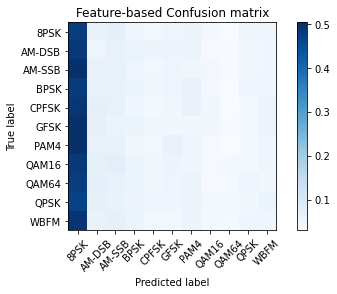

In [17]:
# Plot confusion matrix
classes = mods
model = clf_multilabel
test_Y_hat = model.predict(X_val_std.values)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_val_std.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
plt.savefig('pic\Confusion_Matrix\Feat_CM_CART.jpg',dpi = 300)

In [18]:
# model0:原模型测试
classes = mods
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test_std.values[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]   

    test_Y_i_hat = model.predict(test_X_i)
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    #print("Overall Accuracy: ", cor / (cor+ncor))
    print(cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

0.1206896551724138
0.1572617946345976
0.1663619744058501
0.1451310861423221
0.1634446397188049
0.1478494623655914
0.18439024390243902
0.22698838248436104
0.33524904214559387
0.48892825509300264
0.6840215439856373
0.7660343270099368
0.8062780269058296
0.8142981691368788
0.8394950405770965
0.8555347091932458
0.8465608465608465
0.845724907063197
0.8263254113345521
0.8449197860962567


In [28]:
from art.attacks.evasion import ZooAttack
from art.estimators.classification import XGBoostClassifier


from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier

In [31]:
classifier = SklearnClassifier(
    model=model
)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [28]:
import joblib
joblib.dump(clf_multilabel,'model_saved\Feat_based\XGB_FEAT_basic.pkl')
model = joblib.load('model_saved\Feat_based\XGB_FEAT_basic.pkl')

# Lightgbm

In [86]:
from lightgbm import LGBMClassifier

In [87]:
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

clf_multilabel = OneVsRestClassifier(LGBMClassifier(max_depth=10))

clf_multilabel.fit(X_train_std.values,y_train)

OneVsRestClassifier(estimator=LGBMClassifier(max_depth=10))

In [88]:
from sklearn import datasets,model_selection,metrics,tree,preprocessing
y_pred=clf_multilabel.predict(X_val_std)
# 模型性能评价
print(metrics.accuracy_score(y_pred,y_val))

0.4026299026299026


In [89]:
# model0:原模型测试
classes = mods
model = clf_multilabel
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test_std.values[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]   

    test_Y_i_hat = model.predict(test_X_i)
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    #print("Overall Accuracy: ", cor / (cor+ncor))
    print(cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

0.09165154264972777
0.1036077705827937
0.09323583180987204
0.0898876404494382
0.08875219683655536
0.08422939068100359
0.10536585365853658
0.15281501340482573
0.2796934865900383
0.46058458813108943
0.6364452423698385
0.7172538392050587
0.7551569506726458
0.7715780296425457
0.8034265103697025
0.8189493433395872
0.8209876543209876
0.8234200743494424
0.793418647166362
0.8297682709447415


In [90]:
import joblib
joblib.dump(model,'model_saved\Feat_based\LightGBM_time.pkl')
model = joblib.load('model_saved\Feat_based\LightGBM_time.pkl')